# Izhikevich's pulse-coupled network

This script reproduces the simple pulse-coupled network proposed by Eugene Izhikevich in the article:

**Izhikevich, E.M.** (2003). Simple Model of Spiking Neurons, *IEEE Transaction on Neural Networks, 14:6*.

The original Matlab code is provided below:

```matlab
% Created by Eugene M. Izhikevich, February 25, 2003
% Excitatory neurons Inhibitory neurons
Ne = 800; Ni = 200;
re = rand(Ne,1); ri = rand(Ni,1);
a = [0.02*ones(Ne,1); 0.02+0.08*ri];
b = [0.2*ones(Ne,1); 0.25-0.05*ri];
c = [-65+15*re.^2; -65*ones(Ni,1)];
d = [8-6*re.^2; 2*ones(Ni,1)];
S = [0.5*rand(Ne+Ni,Ne), -rand(Ne+Ni,Ni)];
v = -65*ones(Ne+Ni,1); % Initial values of v
u = b.*v; % Initial values of u
firings = []; % spike timings
for t=1:1000 % simulation of 1000 ms
    I = [5*randn(Ne,1);2*randn(Ni,1)]; % thalamic input
    fired = find(v>=30); % indices of spikes
    firings = [firings; t+0*fired,fired];
    v(fired) = c(fired);
    u(fired) = u(fired) + d(fired);
    I = I + sum(S(:,fired),2);
    v = v + 0.5*(0.04*v.^2 + 5*v + 140 - u + I); % step 0.5 ms
    v = v + 0.5*(0.04*v.^2 + 5*v + 140-u + I); % for numerical
    u = u + a.*(b.*v - u); % stability
end;
plot(firings(:,1),firings(:,2),’.’)
```

## Neuron type

The network is composed of parameterized quadratic integrate-and-fire neurons, known as *Izhikevich* neurons. They are simply defined by the following equations:

$$
    \frac{dv}{dt} = 0.04 \, v^2 + 5 \, v + 140 - u + I 
$$
$$
    \frac{du}{dt} = a \, (b \, v - u)
$$

The spiking mechanism is defined by:

```
    if v > 30.0:
        emit_spike()
        v = c
        u = u + d
```

``v`` is the membrane potential, ``u`` is the membrane recovery variable and ``a``, ``b``, ``c``, ``d`` are parameters allowing to reproduce many types of neural firing.

``I`` is the input voltage to a neuron at each time ``t``. For the desired network, it is the sum of a random value taken from a normal distribution with mean 0.0 and variance 1.0 (multiplied by a scaling factor) and the net effect of incoming spikes (excitatory and inhibitory).

Implementing such a neuron in ANNarchy is straightforward:

```python
    Izhikevich = Neuron(
        parameters="""
            noise = 5.0
            a = 0.02
            b = 0.2
            c = -65.0
            d = 2.0 
            v_thresh = 30.0
        """,
        equations="""
            I = g_exc - g_inh + noise * Normal(0.0, 1.0)
            dv/dt = 0.04 * v^2 + 5.0 * v + 140.0 - u + I 
            du/dt = a * (b*v - u) 
        """,
        spike = """
            v >= v_thresh
        """,
        reset = """
            v = c
            u += d
        """
    )
```

The parameters ``a``, ``b``, ``c``, ``d`` as well as the noise amplitude ``noise`` are declared in the ``parameters`` argument, as their value is constant during the simulation. ``noise`` is declared as the same throughout the population with the ``population`` flag.

The equations for ``v`` and ``u`` are direct translations of their mathematical counterparts. Note the use of ``dx/dt`` for the time derivative and ``^2`` for the square function.

The input voltage ``I`` is defined as the sum of: 

* the total conductance of excitatory synapses ``g_exc``,
* the total conductance of inhibitory synapses ``-g_inh`` (in this example, we consider all weights to be positive, so we need to invert ``g_inh`` in order to model inhibitory synapses),
* a random number taken from the normal distribution $N(0,1)$ and multiplied by the noise scale ``noise``.
  
In the pulse-coupled network, synapses are considered as instantaneous, i.e. a pre-synaptic spikes increases immediately the post-synaptic conductance proportionally to the weight of the synapse, but does not leave further trace. As this is the default behavior in ANNarchy, nothing has to be specified in the neuron's equations.

The ``spike`` argument specifies the condition for when a spike should be emitted (here the membrane potential ``v`` should be greater than ``v_thresh``). The ``reset`` argument specifies the changes to neural variables that should occur after a spike is emitted: here, the membrane potential is reset to the resting potential ``c`` and the membrane recovery variable ``u`` is increased from ``d``.

The ``Izhikevich`` neuron is already defined in ANNarchy, so we will use it directly.

## Defining the populations

We start by defining a population of 1000 Izhikevich neurons and split it into 800 excitatory neurons and 200 inhibitory ones:

In [1]:
from ANNarchy import *
clear()

pop = Population(geometry=1000, neuron=Izhikevich)
Exc = pop[:800]
Inh = pop[800:]

ANNarchy 4.6 (4.6.9b) on linux (posix). 


`Exc` and `Inh` are subsets of `pop`, which have the same properties as a population. We can then set parameters differently for each population:

In [2]:
re = np.random.random(800)      ; ri = np.random.random(200)
Exc.noise = 5.0                 ; Inh.noise = 2.0
Exc.a = 0.02                    ; Inh.a = 0.02 + 0.08 * ri
Exc.b = 0.2                     ; Inh.b = 0.25 - 0.05 * ri
Exc.c = -65.0 + 15.0 * re**2    ; Inh.c = -65.0
Exc.d = 8.0 - 6.0 * re**2       ; Inh.d = 2.0
Exc.v = -65.0                   ; Inh.v = -65.0
Exc.u = Exc.v * Exc.b           ; Inh.u = Inh.v * Inh.b

## Defining the projections

We can now define the connections within the network:

1. The excitatory neurons are connected to all neurons with a weight randomly chosen in [0, 0.5]
2. The inhibitory neurons are connected to all neurons with a weight randomly chosen in [0, 1]

In [3]:
exc_proj = Projection(pre=Exc, post=pop, target='exc')
exc_proj.connect_all_to_all(weights=Uniform(0.0, 0.5))
   
inh_proj = Projection(pre=Inh, post=pop, target='inh')
inh_proj.connect_all_to_all(weights=Uniform(0.0, 1.0))


The network is now ready, we can compile:

In [4]:
compile()

## Running the simulation

We start by monitoring the spikes and membrane potential in the whole population:

In [5]:
M = Monitor(pop, ['spike', 'v'])

We run the simulation for 1000 milliseconds:

In [6]:
simulate(1000.0, measure_time=True)

Simulating 1.0 seconds of the network took 0.3018984794616699 seconds. 


We retrieve the recordings, generate a raster plot and the population firing rate:

In [7]:
spikes = M.get('spike')
v = M.get('v')
t, n = M.raster_plot(spikes)
fr = M.histogram(spikes)

We plot:

1. The raster plot of population
2. The evolution of the membrane potential of a single excitatory neuron
3. The population firing rate

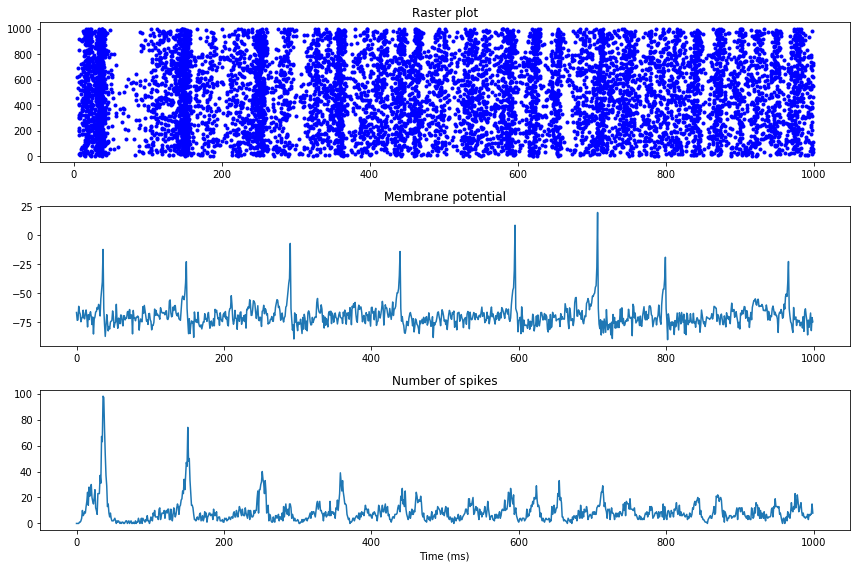

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))

# First plot: raster plot
plt.subplot(311)
plt.plot(t, n, 'b.')
plt.title('Raster plot')

# Second plot: membrane potential of a single excitatory cell
plt.subplot(312)
plt.plot(v[:, 15]) # for example
plt.title('Membrane potential')

# Third plot: number of spikes per step in the population.
plt.subplot(313)
plt.plot(fr)
plt.title('Number of spikes')
plt.xlabel('Time (ms)')

plt.tight_layout()
plt.show()